Activate the project

In [1]:
using Pkg
Pkg.activate(".")

  Activating environment at `~/repos/kp-lflm-group/src/KPpack/Project.toml`


# Load the package KPpack

In [2]:
using KPpack

┌ Info: Precompiling KPpack [26ea0ef3-e7b0-494e-b39b-84c42b7463c6]
└ @ Base loading.jl:1342


# Create a KP model

In [3]:
using Symbolics

In [4]:
## from Igor Vurgaftman, Matthew P. Lumb, and Jerry R. Meyer, Bands and Photons in III-V Semiconductor Quantum Structures,Oxford, 2020 chapter 3
model=["E_g+c*(1+2*F)*(k_x^2+k_y^2+k_z^2)+VBO" "0+im(cp*k_x*P)" "0+im(cp*k_y*P)" "0+im(cp*k_z*P)" "0" "0" "0" "0";
    "0+im(-cp*k_x*P)" "VBO-L*k_x^2-M*(k_y^2+k_z^2)" "-N*k_x*k_y" "-N*k_x*k_z" "0" "0" "0" "0";
    "0+im(-cp*k_y*P)" "-N*k_x*k_y" "VBO-L*k_y^2-M*(k_x^2+k_z^2)" "-N*k_y*k_z" "0" "0" "0" "0";
    "0+im(-cp*k_z*P)" "-N*k_x*k_z" "-N*k_y*k_z" "VBO-L*k_z^2-M*(k_y^2+k_x^2)" "0" "0" "0" "0";
    "0" "0" "0" "0" "E_g+c*(1+2*F)*(k_x^2+k_y^2+k_z^2)+VBO" "0+im(cp*k_x*P)" "0+im(cp*k_y*P)" "0+im(cp*k_z*P)" ;
    "0" "0" "0" "0" "0+im(-cp*k_x*P)" "VBO-L*k_x^2-M*(k_y^2+k_z^2)" "-N*k_x*k_y" "-N*k_x*k_z";
    "0" "0" "0" "0" "0+im(-cp*k_y*P)" "-N*k_x*k_y" "VBO-L*k_y^2-M*(k_x^2+k_z^2)" "-N*k_y*k_z";
    "0" "0" "0" "0" "0+im(-cp*k_z*P)" "-N*k_x*k_z" "-N*k_y*k_z" "VBO-L*k_z^2-M*(k_y^2+k_x^2)";];

strK=["k_x","k_y","k_z"];

HsT= KPpack.createSymbMatrix(model);

Emomentum=KPpack.setMomentum(strK);
HVar=KPpack.getVar(HsT);
#real(HsT)

In [5]:
HstrSOC=["0" "0" "0" "0" "0" "0" "0" "0";
        "0" "0" "0+im*(-d/3)" "0" "0" "0" "0" "d/3";
        "0" "0+im*(d/3)" "0" "0" "0" "0" "0" "0+im*(-d/3)";
        "0" "0" "0" "0" "0" "-d/3" "0+im*(d/3)" "0";
        "0" "0" "0" "0" "0" "0" "0" "0";
        "0" "0" "0" "-d/3" "0" "0" "0+im*(d/3)" "0";
        "0" "0" "0" "0+im*(-d/3)" "0" "0+im*(-d/3)" "0" "0";
        "0" "d/3" "0+im*(d/3)" "0" "0" "0" "0" "0";];
dvar=KPpack.StrtoSymbConv("Δ")
HSOC= KPpack.createSymbMatrix(HstrSOC); HSVar= KPpack.getVar(HSOC);
HSocRe=substitute(real(HSOC),Dict(HSVar[1]=>dvar)); HSocIm=substitute(imag(HSOC),Dict(HSVar[1]=>dvar))
HSOC=HSocRe+im*HSocIm;

In [6]:
L="c*(g_1+4*g_2-(E_p/E_g))"; L=KPpack.StrtoSymbConv(L);
M="c*(g_1-2*g_2)"; M=KPpack.StrtoSymbConv(M)
N="c*(6*g_3-(E_p/E_g))"; N=KPpack.StrtoSymbConv(N)
#D="c*(1+2*F+(E_p/E_g))"; D=KPpack.StrtoSymbConv(D)
#Ac="L+c*(E_p/E_g)"; Ac=KPpack.StrtoSymbConv(Ac); AcVar=Symbolics.get_variables(Ac);Ac=substitute(Ac,Dict(AcVar[1]=>L))
#Cc="N+c*(E_p/E_g)"; Cc=KPpack.StrtoSymbConv(Cc); CcVar=Symbolics.get_variables(Cc);Cc=substitute(Cc,Dict(CcVar[1]=>N));

In [7]:
Hre=real(HsT); Him=imag(HsT) 
#Hre=substitute(Hre,Dict(HVar[3]=>D)); Him=substitute(Him,Dict(HVar[3]=>D)); 
#Hre=substitute(Hre,Dict(HVar[7]=>Ac)); Him=substitute(Him,Dict(HVar[7]=>Ac)); 
Hre=substitute(Hre,Dict(HVar[8]=>L)); Him=substitute(Him,Dict(HVar[8]=>L));
Hre=substitute(Hre,Dict(HVar[9]=>M)); Him=substitute(Him,Dict(HVar[9]=>M));
Hre=substitute(Hre,Dict(HVar[10]=>N)); Him=substitute(Him,Dict(HVar[10]=>N));
#Hre=substitute(Hre,Dict(HVar[9]=>Cc)); Him=substitute(Him,Dict(HVar[9]=>Cc)); 

In [8]:
H8x8=Hre+im*Him;
Htot=H8x8+HSOC;

In [9]:
real(Htot)
#HVar

8×8 Matrix{Num}:
  E_g + VBO + c*(1 + 2F)*(k_x^2 + k_y^2 + k_z^2)  …                         0
 0                                                                   (1//3)*Δ
 0                                                                          0
 0                                                                          0
 0                                                                          0
 0                                                …     -c*k_x*k_z*(6g_3 + (-E_p) / E_g)
 0                                                      -c*k_y*k_z*(6g_3 + (-E_p) / E_g)
 0                                                   VBO - c*(g_1 + 4g_2 + (-E_p) / E_g)*(k_z^2) - c*(g_1 - 2g_2)*(k_x^2 + k_y^2)

In [10]:
var=Emomentum[3] 
H0,H1,H2=KPpack.createKm(Htot,var);


In [11]:
imag(H0)

8×8 Matrix{Num}:
         0  P*cp*k_x   P*cp*k_y          0  …          0         0          0
 -P*cp*k_x         0  (-1//3)*Δ          0             0         0          0
 -P*cp*k_y  (1//3)*Δ          0          0             0         0  (-1//3)*Δ
         0         0          0          0             0  (1//3)*Δ          0
         0         0          0          0      P*cp*k_x  P*cp*k_y          0
         0         0          0          0  …          0  (1//3)*Δ          0
         0         0          0  (-1//3)*Δ     (-1//3)*Δ         0          0
         0         0   (1//3)*Δ          0             0         0          0

## test the bulk calculation

In [12]:
material="GaAs"; Temp=0; soc=true;
tipo="KaneII";
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp)
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

1.519

In [13]:
kmax= 1.4; Nt=100; consth=0.038; const2=0.19
Ktot,Etot=KPpack.calcBandBulk(mm,kmax,Nt,Htot,Emomentum,consth,const2)
#++++++++++++++++++++++++

EDOS, aDOS = KPpack.DOS(-2,2.2,0.01,Etot,0.04);

# Plot band diagram

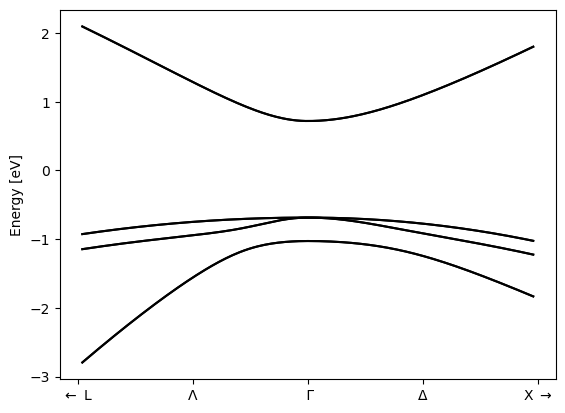

In [14]:
KPpack.PlotBands(Etot,Ktot);

# Plot DOS

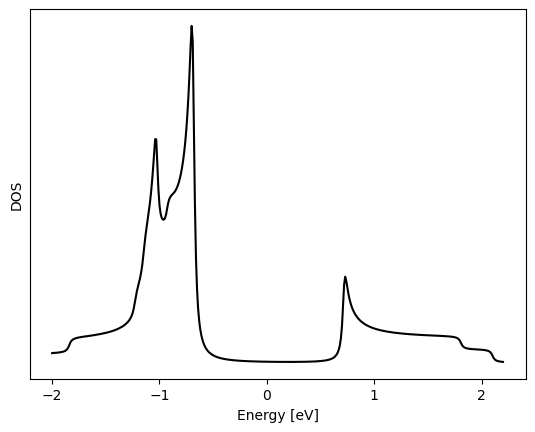

In [15]:
KPpack.PlotDOS(EDOS,aDOS);

# Make a structure

In [16]:
structure=["AlGaAs_1.0" "20";
    "AlGaAs_0.2" "10";
    "GaAs" "6";
    "AlGaAs_0.2" "10";
    "AlGaAs_1.0" "20";]


Npts,layer,nlayer=KPpack.setStructure(structure,0.2)

X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp);


# Plot structure

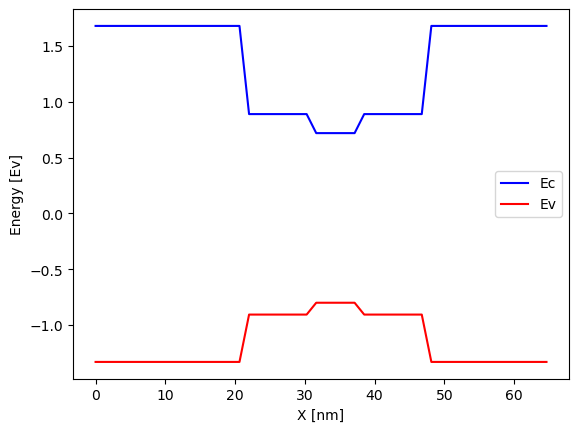

In [17]:
kind="both"
KPpack.plotProf(mlayer,X,kind);

## find eigenvalues solving for K=0

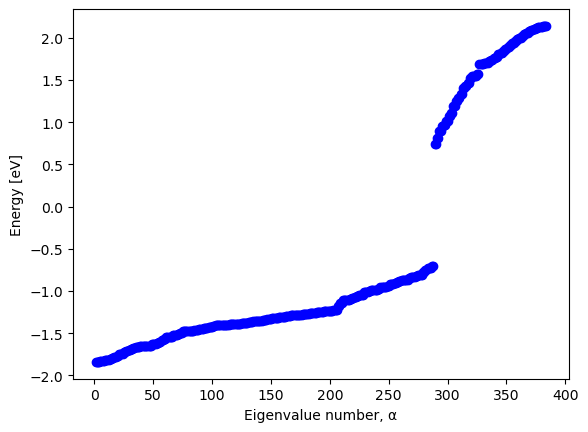

  7.868485 seconds (8.63 M allocations: 526.961 MiB, 3.98% gc time, 89.59% compilation time)


In [18]:
c=0.038; cps=0.19; dx=X[2]-X[1]; pb=true

@time Eqw0, EVqw0=KPpack.EigSolQW(mlayer,Npts,H0,H1,H2,c,cps,dx,Emomentum,pb);
KPpack.PloteigvQW(Npts,Eqw0);

# QW Band Structure Calculation

In [19]:
kmax= 1.3; Nt=100; 
nc=4; nv=2*nc+2
sV,sC,pos=KPpack.eigenValQW(real(Eqw0))

pl=1; pm=1;
@time Ecq11,Evq11,Kqw11 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,H0,H1,H2,nc,nv,c,cps,sV,sC,Emomentum,pb);

pl=1; pm=0;
@time Ecq10,Evq10,Kqw10 =KPpack.DiagQWM(mlayer,kmax+0.1,Nt,dx,pl,pm,Npts,H0,H1,H2,nc,nv,c,cps,sV,sC,Emomentum,pb);

 38.796807 seconds (11.16 M allocations: 2.183 GiB, 1.74% gc time, 14.68% compilation time)
 24.408260 seconds (4.00 M allocations: 1.645 GiB, 1.46% gc time)


## Valence Band 

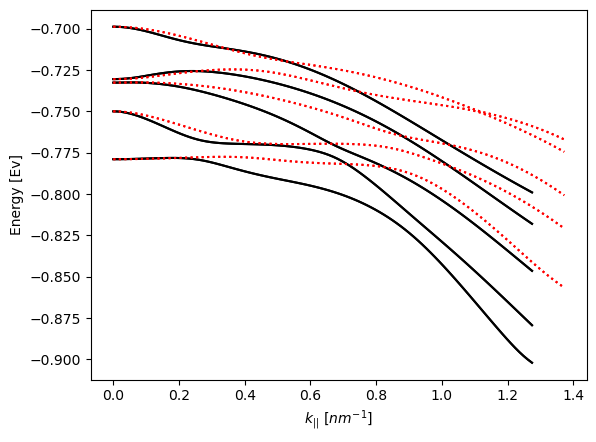

In [20]:
option="comp_V"; poslab=sV
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

## Conduction Band

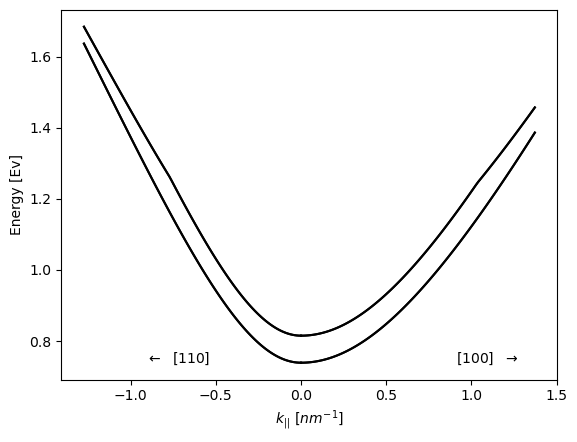

In [21]:
option="complete_C"; poslab=sC
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

# DOS QW

## DOS Valence Band

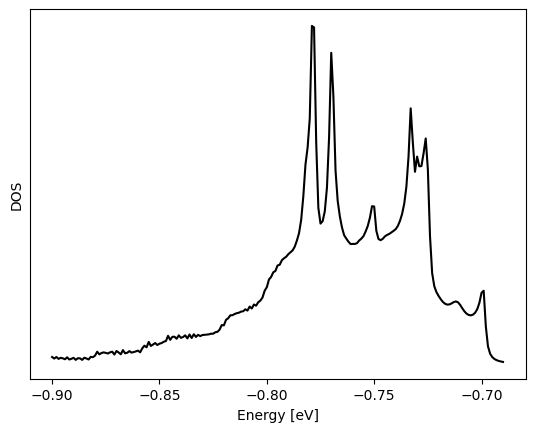

In [22]:
Evqw= vcat(Evq11,Evq10);
EDOSv, aDOSv = KPpack.DOS(-0.9,-0.69,0.001,Evqw,2e-3);
KPpack.PlotDOS(EDOSv,aDOSv);

## DOS Conduction Band

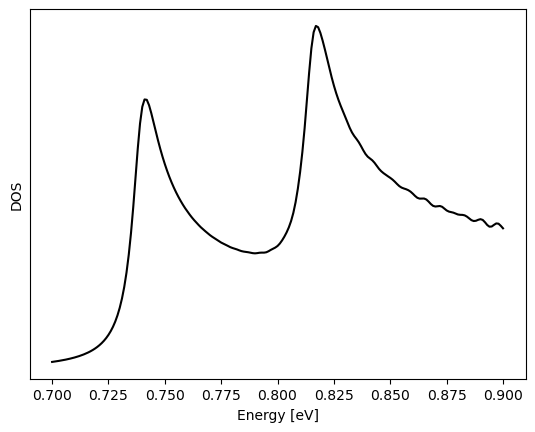

In [23]:
Evqw= vcat(Ecq11,Ecq10);
EDOSc, aDOSc = KPpack.DOS(0.7,0.9,0.001,Evqw,1e-2);
KPpack.PlotDOS(EDOSc,aDOSc);

In [24]:
kx,ky=0.0,0.0
hns=KPpack.FDHamiltonian(H0,H1,H2,mlayer,kx,ky,dx,c,cps,Npts,Emomentum,pb)

384×384 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 2112 stored entries:
⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓
⠀⠻⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠹⣿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠙⣿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢿⣷⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣿⣿⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣿⣿⣄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣿⣿⣆⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣦⠀
⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢿⣷

In [25]:
hns-hns'

384×384 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 288 stored entries:
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⢮⡳⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⣮⡻⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⢮⡳⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

save a file with band structure

In [26]:
# save a file in folder data with a name given by the user
dat=hcat(Ktot,Etot);
name="BandStructure_GaAs_1"
KPpack.writefile(dat,name)

# Symbolic

## create a Finite differences matrices

# ====================================================================================

In [27]:
A,B,C=KPpack.constructMatrixFD(H0,H1,H2);
exclude=["k_x","k_y","k_z","c","cp"]; b1="r"; b2="l"
excS=KPpack.setExcludePar(exclude)
PrH=KPpack.getVar(Htot)
Al,Ar,Bl,Br,Cr,Cl=KPpack.createBmatrizFD(H0,H1,H2,PrH,excS,b1,b2);


In [28]:
mt=real(H2)

8×8 Matrix{Num}:
 c*(1 + 2F)*(k_x^2 + k_y^2) - c*(1 + 2F)*(1 + k_x^2 + k_y^2)  …       0
        0                                                             0
        0                                                             0
        0                                                             0
        0                                                             0
        0                                                     …       0
        0                                                             0
        0                                                        -((c*(E_p - E_g*g_1 - 4E_g*g_2)) / E_g)

In [29]:
simplify(mt[2,2])

c*(1 + k_y^2)*(g_1 - 2g_2) - c*(g_1 - 2g_2)*(k_y^2)

In [30]:
imag(Htot)

8×8 Matrix{Num}:
         0  P*cp*k_x   P*cp*k_y   P*cp*k_z  …          0         0          0
 -P*cp*k_x         0  (-1//3)*Δ          0             0         0          0
 -P*cp*k_y  (1//3)*Δ          0          0             0         0  (-1//3)*Δ
 -P*cp*k_z         0          0          0             0  (1//3)*Δ          0
         0         0          0          0      P*cp*k_x  P*cp*k_y   P*cp*k_z
         0         0          0          0  …          0  (1//3)*Δ          0
         0         0          0  (-1//3)*Δ     (-1//3)*Δ         0          0
         0         0   (1//3)*Δ          0             0         0          0

# ================================

In [31]:
using PyCall, PyPlot

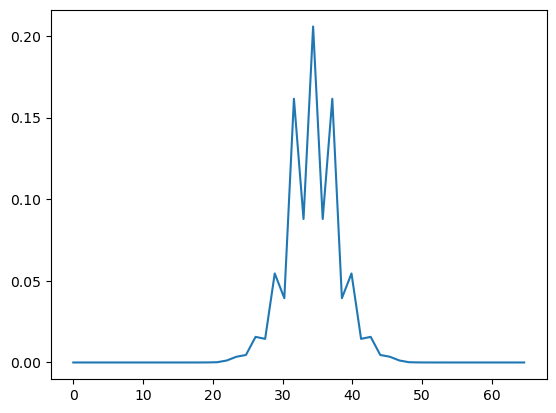

0.7388335623525606 + 1.6787995266715044e-18im

In [32]:
i=pos+1


Evec=EVqw0[5:8:end,i]

vv=Evec.*transpose(Evec')
#vv=real(vec)
#lt.xlim(150,250)
plt.plot(X,real(vv))
Eqw0[i]

In [33]:
str="3*f+2*sin(x)*exp(x)+im(cos(x)^2+atan(x)^2)"
exprs=KPpack.StrtoSymbComplexConv(str);

In [34]:
real(exprs)

3f + 2exp(x)*sin(x)

In [35]:
imag(exprs)

atan(x)^2 + cos(x)^2

In [36]:
typeof(exprs)

Complex{Num}